In [1]:
%%capture
!pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate

In [2]:
import torch
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from torchvision.utils import save_image

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Creating datasets


torch.Size([3, 256, 256])


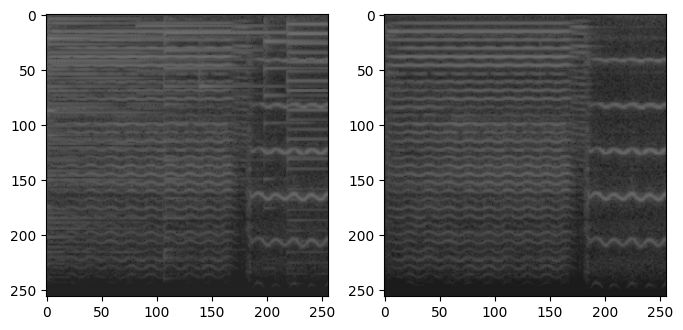

In [3]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=3
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=3
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=3
                     )

img1,img2=train_ds[0]
print(img1.shape)

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

### Model setup

In [4]:
model=PixelDiffusionConditional(train_ds,
                                valid_dataset=valid_ds,
                                lr=1e-5,
                                batch_size=4,
                                num_timesteps=1000)

Is Time embed used ?  True


### Training

In [5]:
trainer = pl.Trainer(
    default_root_dir="trained_models/diffusion/3_channels_cosine/",
    max_epochs=3000,
    callbacks=[EMA(0.9999)],
    accelerator='auto'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.479   Total estimated model params size (MB)


### Load checkpoint

In [ ]:
torch.set_float32_matmul_precision('high')
trainer.fit(model, ckpt_path='trained_models/diffusion/3_channels_cosine/lightning_logs/version_3/checkpoints/epoch=1104-step=138125.ckpt')

Restoring states from the checkpoint path at trained_models/diffusion/3_channels_cosine/lightning_logs/version_3/checkpoints/epoch=1104-step=138125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.479   Total estimated model params size (MB)
Restored all states from the checkpoint at trained_models/diffusion/3_channels_cosine/lightning_logs/version_3/checkpoints/epoch=1104-step=138125.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Create Sample

In [7]:
song_num = 3
condition,target=test_ds[song_num]
batch_input=torch.stack(1*[condition],0)

out=model(batch_input, verbose=True)

diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

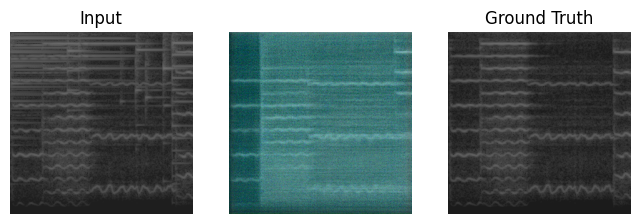

In [9]:
plt.subplot(1,2+len(out),1)
plt.imshow(condition.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(target.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

In [26]:
from torchvision.utils import save_image
phase = test_ds.get_phase(song_num)

name = test_ds.files[song_num]
test_ds.save_audio(out[0].detach().cpu(), phase, name = 'produced_' +  name)
test_ds.save_audio(target, phase, name = 'target_' + name)
test_ds.save_audio(condition, phase, name = 'condition_' + name)
save_image(out[0], 'results/produced_' + name.replace('wav','png'))
save_image(condition, 'results/condition_' + name.replace('wav','png'))
save_image(target, 'results/target_' + name.replace('wav','png'))